In [305]:
import numpy as np
import matplotlib.pyplot as plt
import numba

$u_t + u_x = 0$

In [342]:
real = np.float64
# @numba.njit
def rhs_scalar(U: real, dx: real, dt: real, bc_type: str = "FOExtrap", flux_type: str="weno") -> real:
    # Fill ghost cells
    if (flux_type=="weno"):
        ng=3
    elif (flux_type=="rusanov"):
        ng=1
    elif (flux_type=="central2"):
        ng=1
    elif (flux_type=="central4"):
        ng=2
    else:
        raise NotImplementedError
    U_border = fill_ghost_cell(ng, U, bc_type)

    # Compute fluxes

    if (flux_type=="weno"):
        flx = np.zeros((U.shape[0]+1, U.shape[1]), dtype=real)
        for i in range(U.shape[0]+1):
            fp = U_border[i:i+2*ng,:]
            # FL
            flx[i,:] = weno(np.flip(fp[:2*ng-1,0]))
        # (FL - FR)/dx
        flx_der = (flx[:-1,:] - flx[1:,:]) / dx
    elif(flux_type=="rusanov"):
        flx = np.zeros((U.shape[0]+1, U.shape[1]), dtype=real)
        for i in range(U.shape[0]+1):
            fp = U_border[i:i+2*ng,0]
            # i+1/2 but it corresponds to FL of ith cell in domain
            # The wave speed is 1
            flx[i,:] = 0.5*(fp[0]+fp[1]) - 0.5*(1)*(fp[1] - fp[0])
        # rhs = - (FR-FL)/dx = (FL - FR)/dx
        flx_der = (flx[:-1,:] - flx[1:,:]) / dx
    elif(flux_type=="RD"):
        raise NotImplementedError
    elif(flux_type=="central2"):
        flx = np.zeros((U.shape[0], U.shape[1]), dtype=real)
        for i in range(U.shape[0]):
            fp = U_border[i:i+2*ng+1,0]
            flx[i,0] = (-0.5*fp[0] + 0.5*fp[2])/dx
        flx_der = -flx[:] 
    elif(flux_type=="central4"):
        flx = np.zeros((U.shape[0], U.shape[1]), dtype=real)
        for i in range(U.shape[0]):
            fp = U_border[i:i+2*ng+1,0]
            flx[i,0] = ((1/12.0)*fp[0] + (-2/3.0)*fp[1] + (2/3.0)*fp[3] + (-1/12.0)*fp[4])/dx
        flx_der = -flx[:]
    else:
        print("flux_type not defined correctly")
        raise NotImplementedError

    return flx_der

# @numba.njit
def rk3_scalar(U: real, dx: real, dt: real, bc_type: str = "FOExtrap", flux_type: str="weno") -> real:
    # SSP-RK3
    U1 = U + dt * rhs_scalar(U, dx, dt, bc_type)
    U2 = 0.75 * U + 0.25 * (U1 + dt * rhs_scalar(U1, dx, dt, bc_type, flux_type))
    return (U + 2*(U2 + dt * rhs_scalar(U2, dx, dt, bc_type, flux_type))) / 3

def f_euler_scalar(U: real, dx: real, dt: real, bc_type: str = "FOExtrap", flux_type: str="weno") -> real:
    return (U + dt * rhs_scalar(U, dx, dt, bc_type, flux_type))


# @numba.njit
def fill_ghost_cell(ng: int, U: real, bc_type: str) -> real:
    U_border = np.zeros((U.shape[0]+2*ng, U.shape[1]), dtype=real)
    U_border[ng:-ng,:] = U
    if bc_type == "FOExtrap":
        U_border[:ng,:] = U[0,:]
        U_border[-ng:,:] = U[-1,:]
    elif bc_type == "periodic":
        U_border[:ng,:] = U[-ng:,:]
        U_border[-ng:,:] = U[:ng,:]
    # elif bc_type == "reflect":
    #   U_border[:ng,:] = U[ng:-1:,:]
    #   U_border[-ng:,:] = U[-ng:-1:,:]
    else:
        raise NotImplementedError
    return U_border

In [334]:
# @numba.njit
def weno(s: real) -> real:
  # WENO Z5. Ref: https://doi.org/10.1016/j.jcp.2007.11.038
  eps = 1e-6
  v = np.empty((3,), dtype=real)
  beta = np.empty((3,), dtype=real)

  beta[2] = (13. / 12.) * (s[4] - 2 * s[3] + s[2])**2 + 0.25 * (s[4] - 4 * s[3] + 3 * s[2])**2
  beta[1] = (13. / 12.) * (s[3] - 2 * s[2] + s[1])**2 + 0.25 * (s[3] - s[1])**2
  beta[0] = (13. / 12.) * (s[2] - 2 * s[1] + s[0])**2 + 0.25 * (3 * s[2] - 4 * s[1] + s[0])**2

  tau = np.abs(beta[2] - beta[0])
  beta[2] = 1.0 + tau / (eps + beta[2])
  beta[1] = (1.0 + tau / (eps + beta[1])) * 6.0
  beta[0] = (1.0 + tau / (eps + beta[0])) * 3.0
  beta1 = 1.0 / (beta[2] + beta[1] + beta[0])

  v[2] = 11 * s[2] - 7 * s[3] + 2 * s[4]
  v[1] = -s[3] + 5 * s[2] + 2 * s[1]
  v[0] = 2 * s[2] + 5 * s[1] - s[0]

  sm = beta1 / 6.0 * (beta[2] * v[2] + beta[1] * v[1] + beta[0] * v[0])
  # if (np.isnan(sm)): print("WARNING: isnan(sm)")
  return sm

In [335]:
def simple_wave_ic(x):
    a = 1.0
    k = 1.0
    return a*np.sin(2*np.pi*k*x)

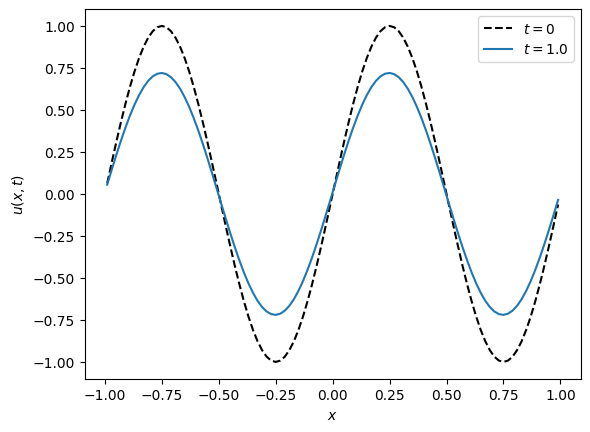

In [338]:
Ncells = 100
x = np.linspace(-1.0, 1.0, Ncells+1, dtype=real)
x = (x[:-1] + x[1:]) / 2
u = simple_wave_ic(x)[:, np.newaxis]
plt.plot(x, u, 'k--', label=rf"$t = 0$")

dx = x[1] - x[0]
t_end = 1.0
dt = 0.002

for _ in range(int(t_end/dt)):
    u = rk3_scalar(u, dx, dt, bc_type="periodic",flux_type="rusanov")

plt.plot(x, u, label=rf"$t = {t_end}$")
plt.xlabel("$x$")
plt.ylabel("$u(x,t)$")
plt.legend()

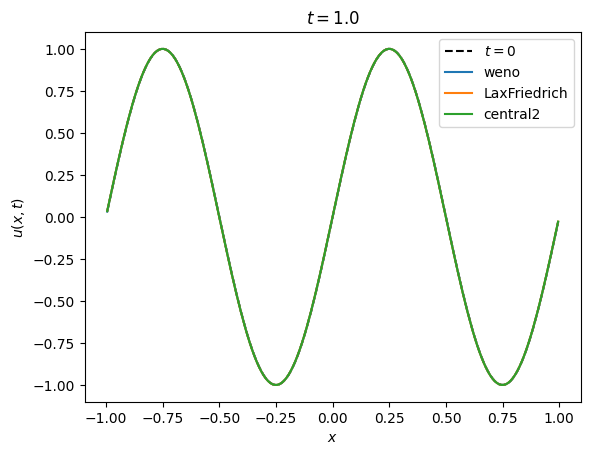

In [286]:
Ncells = 200
x = np.linspace(-1.0, 1.0, Ncells+1, dtype=real)
x = (x[:-1] + x[1:]) / 2
u0 = simple_wave_ic(x)[:, np.newaxis]
plt.plot(x, u0, 'k--', label=rf"$t = 0$")

dx = x[1] - x[0]
t_end = 1.0
dt = 0.002

u_weno=np.copy(u0)
for _ in range(int(t_end/dt)):
    u_weno = rk3_scalar(u_weno, dx, dt, bc_type="periodic",flux_type="weno")

u_rusanov=np.copy(u0)
for _ in range(int(t_end/dt)):
    u_rusanov = rk3_scalar(u_rusanov, dx, dt, bc_type="periodic",flux_type="LaxFriedrich")

u_central=np.copy(u0)
for _ in range(int(t_end/dt)):
    u_central = rk3_scalar(u_central, dx, dt, bc_type="periodic",flux_type="central2")


plt.plot(x, u_weno, label="weno")
plt.plot(x, u_rusanov, label="LaxFriedrich")
plt.plot(x, u_central, label="central2")
plt.title(rf"$t = {t_end}$")
plt.xlabel("$x$")
plt.ylabel("$u(x,t)$")
plt.legend()

### Complex wave

In [343]:
def complex_wave_ic(x):
    a = 0.5
    z = 0.7
    delta = 0.005
    alpha = 10.0
    beta = 3.6/delta
    G = lambda x, l: np.exp(-beta*(x-l)**2)
    F = lambda x, l: np.sqrt(np.maximum(1-(alpha*(x-l))**2, 0.0))

    u = ((np.abs(x+0.7) <= 0.1)*(G(x,-z)) +
       (np.abs(x+0.3) <= 0.1) +
       (np.abs(x-0.1) <= 0.1)*(1.0-np.abs(10.0*x-1.0)) +
       (np.abs(x-0.5) <= 0.1)*(F(x,a-delta)+F(x,a+delta)+4*F(x,a))/6)
    return u

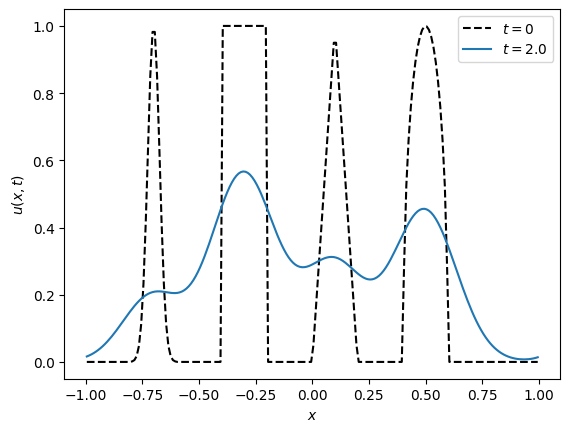

In [345]:
Ncells = 200
x = np.linspace(-1.0, 1.0, Ncells+1, dtype=real)
x = (x[:-1] + x[1:]) / 2
u = complex_wave_ic(x)[:, np.newaxis]
plt.plot(x, u, 'k--', label=rf"$t = 0$")

dx = x[1] - x[0]
t_end = 2.0
dt = 0.002

for _ in range(int(t_end/dt)):
    u = rk3_scalar(u, dx, dt, bc_type="periodic",flux_type="rusanov")

plt.plot(x, u, label=rf"$t = {t_end}$")
plt.xlabel("$x$")
plt.ylabel("$u(x,t)$")
plt.legend()

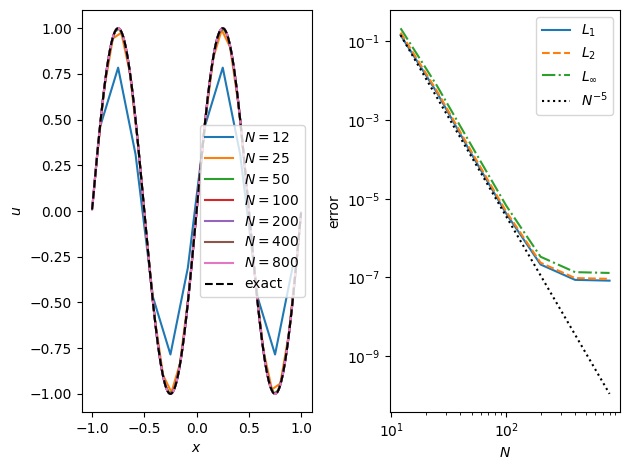

In [104]:
# Convergence
N = [12, 25, 50, 100, 200, 400, 800]
err = []
plt.subplot(121)
for n in N:
  x = np.linspace(-1.0, 1.0, n+1, dtype=real)
  x = (x[:-1] + x[1:]) / 2
  u0 = np.sin(2*np.pi*x)[:, np.newaxis]
  # u0 = (x*np.exp(-16*x**2))[:, np.newaxis]
  u = u0
  dx = x[1] - x[0]
  t_end = 2.0
  dt = 0.001

  for _ in range(int(t_end/dt)):
    u = rk3_scalar(u, dx, dt, bc_type="periodic")
  plt.plot(x, u, label=rf"$N = {n}$")

  err.append([np.mean(np.abs(u-u0)),
              np.sqrt(np.mean((u-u0)**2)),
              np.max(np.abs(u-u0))])

N = np.array(N)
err = np.array(err)
plt.plot(x, u0, "k--", label="exact")
plt.xlabel("$x$")
plt.ylabel("$u$")
plt.legend()

plt.subplot(122)
plt.loglog(N, err[:,0], label="$L_1$")
plt.loglog(N, err[:,1], "--", label="$L_2$")
plt.loglog(N, err[:,2], "-.", label="$L_\infty$")
plt.loglog(N, err[0,0]*N[0]**5/N**5, "k:", label="$N^{-5}$")
plt.xlabel("$N$")
plt.ylabel("error")
plt.legend()

plt.tight_layout()

# Notes: the convergence is limited by timestep at large N